In [1]:
import os
import urllib
import urllib.request
import zipfile

class DataIngestion:
    def __init__(self, source_url, download_path, extract_path):
        self.url = source_url
        self.download_path = download_path
        self.extract_path = extract_path

    def download_file(self):
        if not os.path.exists(self.download_path):
            filename, _ = urllib.request.urlretrieve(url = self.url, filename=self.download_path)
            print(f"{filename} downloaded successfully !")
        else:
            size_mb = round(os.path.getsize(self.download_path)/(1024**2))
            print(f"File already exists of size {size_mb}MB")

    def extract_zip_file(self):
        os.makedirs(self.extract_path, exist_ok=True)
        with zipfile.ZipFile(self.download_path, 'r') as unzipper:
            unzipper.extractall(self.extract_path)
        print(f"Unzipped data to {self.extract_path}")

In [2]:
downloader = DataIngestion(source_url = "https://zenodo.org/records/3251771/files/Webis-CPC-11.zip?download=1",download_path="dataset", extract_path="data")

downloader.download_file()

dataset downloaded successfully !


In [3]:
downloader.extract_zip_file()

Unzipped data to data


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup, Trainer, TrainingArguments
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
data_size = len(os.listdir("./data/Webis-CPC-11"))

data_size = data_size//3

In [ ]:
data = []

for i in range(1, data_size+1):
    original = open('./data/Webis-CPC-11/'+str(i)+'-original.txt', 'r')
    original = original.read()

    paraphrase = open('./data/Webis-CPC-11/'+str(i)+'-paraphrase.txt', 'r')
    paraphrase = paraphrase.read()

    with open('./data/Webis-CPC-11/'+str(i)+'-metadata.txt', 'r') as f:
        for line in f:
            key, value = line.strip().split(':')
            if key == 'Paraphrase':
                label = value.strip()

    sample = [original, paraphrase, label]
    data.append([s.replace('\n',' ') for s in sample])

In [ ]:
data[0]

['M. Comte would not advise so irrational a proceeding.  But M. Comte has himself a constructive doctrine; M. Comte will give us in exchange--what? The Scientific Method!  We have just seen something of this scientific method. ',
 'Even M. Comte would spurn such irrational reasoning.  However, M. Comte adheres himself to a fruitful belief, one which he will offer us instead - the Scientific Method!  This scientific method has, in fact, just been observed. ',
 'Yes']

In [ ]:
df =pd.DataFrame(np.array(data), columns=['original', 'paraphrase', 'label'])
df['label'] = df['label'].map({'Yes':1,'No':0})
df.head()

,original,paraphrase,label
0,M. Comte would not advise so irrational a proc...,Even M. Comte would spurn such irrational reas...,1
1,Without enumerating all the modern authors who...,Just without specifying the current writers wh...,1
2,"Therefore, a person should search his actions ...","As such, a person should analyze what he did a...",1
3,"""I have heard many accounts of him,"" said Emil...","Emily said, ""I have heard many different thing...",1
4,"""I have heard many accounts of him,"" said Emil...","""I have heard many accounts of him,"" said Emil...",0


In [ ]:
size = len(df)
train_df = df[:int(size*0.8)]
val_df = df[int(size*0.8):]
test_df = val_df[:int(len(val_df)*0.4)]
val_df = val_df[int(len(val_df)*0.4):]


print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 6287
Validation size: 944
Test size: 628


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
train_encodings = tokenizer(train_df['original'].tolist(), train_df['paraphrase'].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df['original'].tolist(), val_df['paraphrase'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['original'].tolist(), test_df['paraphrase'].tolist(), truncation=True, padding=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
for x in train_encodings:
    print(x)

input_ids
attention_mask


In [ ]:
print(train_encodings['input_ids'][0])
print("="*300)
print(train_encodings['attention_mask'][0])

[0, 448, 4, 4556, 859, 74, 45, 12922, 98, 31338, 10, 19635, 4, 1437, 125, 256, 4, 4556, 859, 34, 1003, 10, 17915, 26944, 131, 256, 4, 4556, 859, 40, 492, 201, 11, 2081, 5579, 12196, 116, 20, 17141, 16410, 328, 1437, 166, 33, 95, 450, 402, 9, 42, 6441, 5448, 4, 1437, 2, 2, 8170, 256, 4, 4556, 859, 74, 2292, 8629, 215, 31338, 20511, 4, 1437, 635, 6, 256, 4, 4556, 859, 2329, 29492, 1003, 7, 10, 31770, 6563, 6, 65, 61, 37, 40, 904, 201, 1386, 111, 5, 17141, 16410, 328, 1437, 152, 6441, 5448, 34, 6, 11, 754, 6, 95, 57, 6373, 4, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
class ParaphraseDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ParaphraseDataset(train_encodings, train_df['label'].tolist())
val_dataset = ParaphraseDataset(val_encodings, val_df['label'].tolist())
test_dataset = ParaphraseDataset(test_encodings, test_df['label'].tolist())

In [ ]:
from getpass import getpass

os.environ['HUGGINGFACE_TOKEN'] = getpass()

··········


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('FacebookAI/roberta-base', num_labels=2)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=30,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.05,
    learning_rate=3e-5,
    logging_dir='./logs',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=lambda data: {'input_ids': torch.stack([item['input_ids'] for item in data]),
                                'attention_mask': torch.stack([item['attention_mask'] for item in data]),
                                'labels': torch.tensor([item['labels'] for item in data])},
    compute_metrics=lambda pred: {'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1))}
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: amaanrzv786 (amaanrzv786-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.496374,0.687500
2,No log,0.489506,0.832627
3,0.485600,0.371149,0.842161
4,0.485600,0.328905,0.846398
5,0.485600,0.411227,0.855932
6,0.292800,0.587247,0.845339
7,0.292800,0.535260,0.828390
8,0.149300,0.606855,0.827331
9,0.149300,0.922454,0.846398
10,0.149300,1.313327,0.842161


TrainOutput(global_step=5910, training_loss=0.09230403027760398, metrics={'train_runtime': 7908.2091, 'train_samples_per_second': 23.85, 'train_steps_per_second': 0.747, 'total_flos': 4.96253761514496e+16, 'train_loss': 0.09230403027760398, 'epoch': 30.0})

In [ ]:
# Get the predicted labels for the test dataset
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Get the true labels for the test dataset
true_labels = test_df['label'].tolist()

print('Accuracy:', accuracy_score(true_labels, predicted_labels))

Accuracy: 0.821656050955414


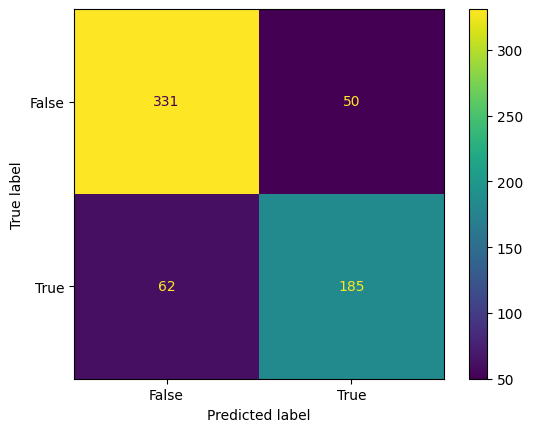

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import login

login(token=os.environ['HUGGINGFACE_TOKEN'])
trainer.push_to_hub("Amaan39/Roberta-Webis-CPC")


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Amaan39/results/commit/2a9fedc707419a0299a99667ea1bef6ff5e39bad', commit_message='Amaan39/Roberta-Webis-CPC', commit_description='', oid='2a9fedc707419a0299a99667ea1bef6ff5e39bad', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Amaan39/results', endpoint='https://huggingface.co', repo_type='model', repo_id='Amaan39/results'), pr_revision=None, pr_num=None)

In [7]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification
import dotenv

dotenv.load_dotenv()

MODEL_NAME = "Amaan39/Roberta-Webis-CPC"
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

In [9]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="Amaan39/Roberta-Webis-CPC")

OSError: Can't load tokenizer for 'Amaan39/Roberta-Webis-CPC'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'Amaan39/Roberta-Webis-CPC' is the correct path to a directory containing all relevant files for a RobertaTokenizerFast tokenizer.